# <center> Predictive modelling in Production <center/>
<center> <b>DLBDSMTP01<b/> - From Model to Production <center/>
<center> IU International University of Applied Sciences <center/>

Hello, in this project, our objective is to establish an anomaly detection system for a production environment. This notebook is specifically crafted to initiate the project's first step: __building the predictive model__. Our approach involves training various models using mlflow, selecting the one with the most favorable metrics during evaluation, and keep monitoring them while deployed.

## List of contents : 
1. Overview
2. Creating models
3. Training/testing
4. Evaluation
4.1. _Actual vs. Predicted values Plot_
4.2. _Residuals Plots_
4.3. _Metrics_
5. Monitoring
6. Summary

Start with importing the required libraries :

In [2]:
# Importing the required libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import mlflow

# Avoid unnecessary warnings
import warnings

warnings.filterwarnings("ignore")

### 1. Overview 
The data we'll use is fictitious, created to reflect the typical operational conditions of the manufacturing machines during regular operation. These conditions are around the following ranges :
* __Sound__       : Between 60 dB and 85 dB.
* __Temperature__ : Between 68°F and 86°F. 
* __Humidity__    : Between 40% and 60% of RH.

Starting with loading the data

In [3]:
# Formulating the directory 
path = Path.cwd().parent

# Loading the data
data = pd.read_csv(f'{path}/data/data_v1.0.csv')
data.sample(15)

,sound,temperature,humidity,score
5254,66,84,50,5.43
7730,80,82,45,4.43
6388,74,80,49,5.00
3766,79,69,47,6.14
2324,62,84,45,6.71
1762,78,69,41,7.14
5360,73,72,55,5.43
1527,75,71,41,7.29
179,61,72,44,8.71
5910,63,86,53,5.14


In [3]:
# Getting basic descriptive statistics
data.describe()

,sound,temperature,humidity,score
count,10379.000000,10379.000000,10379.000000,10379.000000
mean,72.492533,76.994219,49.993737,5.498796
std,7.506329,5.482586,6.060931,1.584779
min,55.000000,63.000000,35.000000,1.000000
25%,66.000000,72.000000,45.000000,4.430000
50%,72.000000,77.000000,50.000000,5.430000
75%,79.000000,82.000000,55.000000,6.570000
max,85.000000,86.000000,60.000000,10.000000


### 2. Creating models 
Subsequently, the following models are chosen to become our model :
* Linear Regression. 
* Decision Tree.
* Random Forest.
* Support Vector Machine.

In [4]:
# Dictionary to store models 
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR()
}

### 3. Training/Testing
Next, the models created are going to be trained on 70% of the data and tested on the rest.

In [5]:
# Specifying the train/test data
X_train, X_test, y_train, y_test = train_test_split(
    data[['sound', 'temperature', 'humidity']], data['score'],
    test_size=0.3
)

# Setting a default tracking directory
mlflow.set_tracking_uri(f"file:{path}/mlruns")

# Starting a new experiment
mlflow.create_experiment("Training prospected models")

for model_name, model_instance in models.items():
    # Tagging the experiment (if needed)
    mlflow.set_experiment("Training prospected models")
    
    # Starting a run
    with mlflow.start_run(run_name=f'Training {model_name}'):
        # Training the model
        model_instance.fit(X_train, y_train)

        # Evaluating the model
        y_estimate = model_instance.predict(X_test)

        # Measuring accuracy of the model
        mse = mean_squared_error(y_test, y_estimate)
        rmse = root_mean_squared_error(y_test, y_estimate)
        mae = mean_absolute_error(y_test, y_estimate)
        r2 = r2_score(y_test, y_estimate)
        
        # Logging the model        
        mlflow.sklearn.log_model(sk_model=model_instance, artifact_path="model",
                                 registered_model_name=model_name)

        # Logging metrics
        mlflow.log_metrics({"MSE": mse, "RMSE": rmse, "MAE": mae, "R-squared": r2})

Successfully registered model 'Linear Regression'.
Created version '1' of model 'Linear Regression'.
Successfully registered model 'Decision Tree'.
Created version '1' of model 'Decision Tree'.
Successfully registered model 'Random Forest'.
Created version '1' of model 'Random Forest'.
Successfully registered model 'Support Vector Machine'.
Created version '1' of model 'Support Vector Machine'.


### 4. Evaluation
Based on the results of this phase, the model with better metrics is chosen. The following screenshot provides on overview on how these models are being compared to each other. 

#### 4.1. Actual vs. Predicted Values Plot:
This plot a visual overview describing the difference between actual and the predicted data.

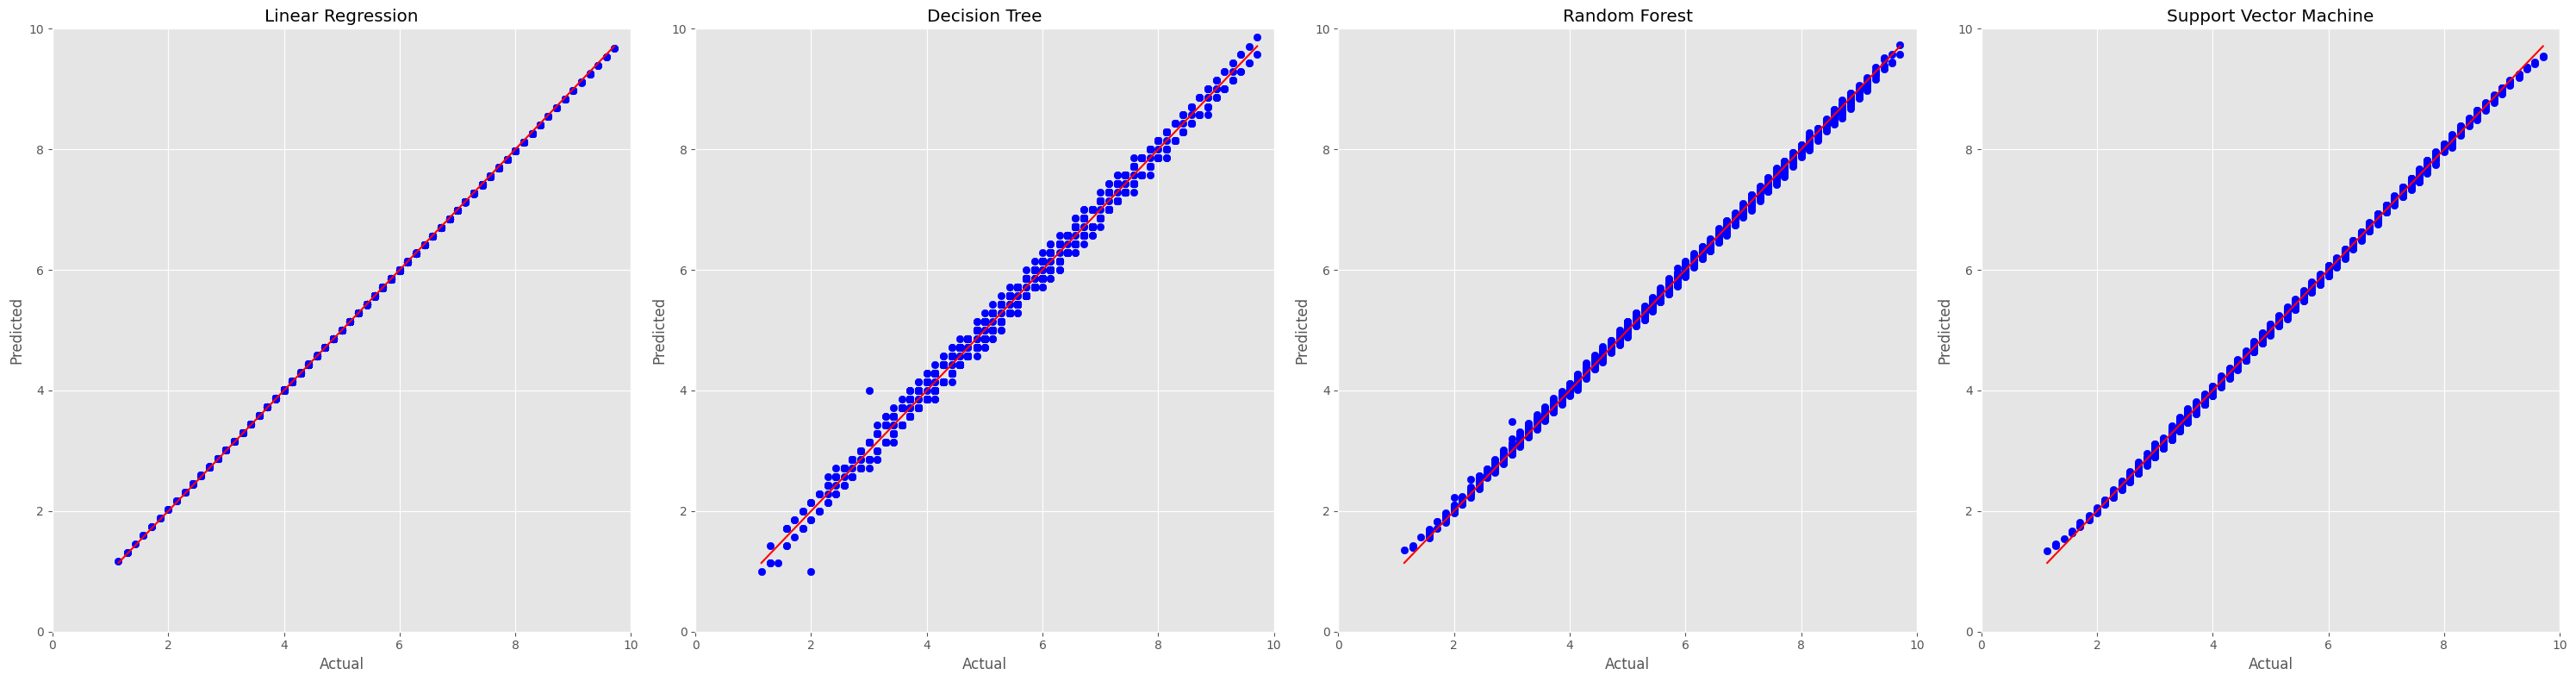

In [6]:
# Setting the visualization style
plt.style.use("ggplot")

# Initiating a 2x2 grid
fig, ax = plt.subplots(1, 4, figsize=(30, 8))
ax = ax.flatten()

# Running the loop to plot the scatter plot
for i, model in enumerate(models):
    # Gathering the model's predictions
    y_pred = models[model].predict(X_test)

    # Plotting the Actual data line
    ax[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red")

    # Plotting the Predicted data points
    ax[i].scatter(y_test, y_pred, color="blue")
    ax[i].set_xlim([0, 10])
    ax[i].set_ylim([0, 10])
    ax[i].set_xlabel("Actual")
    ax[i].set_ylabel("Predicted")
    ax[i].set_title(model)

# Displaying the plot
plt.tight_layout()
plt.show()

#### 4.2. Residuals Plot:
Plotting the residuals _(the differences between actual and predicted values)_ against the predicted values helps identify patterns or trends in the errors.

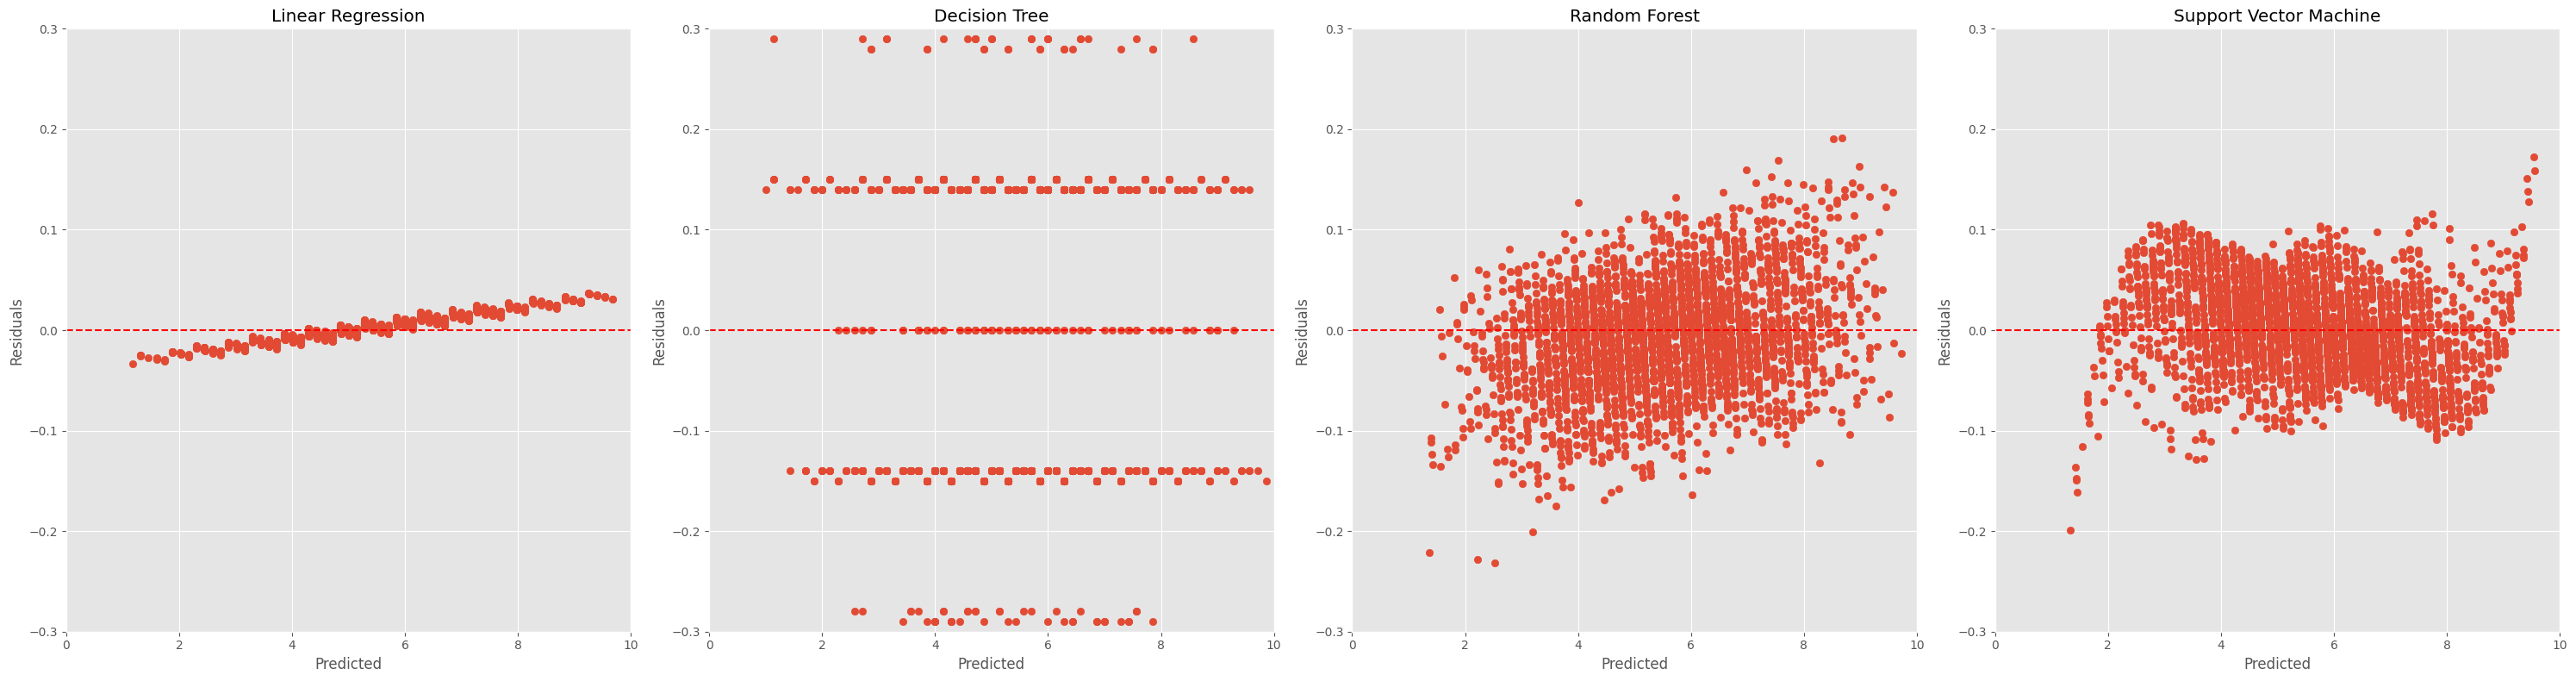

In [7]:
# Initiating a 1x4 grid
fig2, ax = plt.subplots(1, 4, figsize=(30, 8))
ax2 = ax.flatten()

# Running the loop to plot the scatter plot
for i, model in enumerate(models):
    # Gathering the model's predictions
    y_pred = models[model].predict(X_test)

    # Calculating residuals
    residuals = y_test - y_pred

    # Drawing Line at y=0 for reference
    ax2[i].axhline(y=0, color="red", linestyle="--")

    # Plotting the scatter 
    ax2[i].scatter(y_pred, residuals)
    ax2[i].set_xlabel("Predicted")
    ax2[i].set_ylabel("Residuals")
    ax2[i].set_xlim([0, 10])
    ax2[i].set_ylim([-0.3, 0.3])
    ax2[i].set_title(model)

# Displaying the plot
plt.tight_layout()
plt.show()

#### 4.3. Metrics:
Taken from __mlflow UI__, the following screenshot provides a visual comparison between metrics of the 4 models.

![Metrics Of the Models](file:///C:/Users/Dell/Desktop/MTP01/notebooks/figures/Fig.1.png)

#### 4.4. Best Model:
In this project, 4 models underwent training on fictional data. The models included _Linear Regression_, _Decision Tree_, _Random Forest_, and _Support Vector Machine_. 
Upon evaluating these models, it was determined that __Linear Regression__ stood out as the most efficient for the dataset and the preceding visualization effectively depicted the distinctions among the models.

In [9]:
import mlflow.sklearn

# Save the best model
mlflow.sklearn.save_model(models["Linear Regression"],
                          f"{path}/models/Linear Regression")

# Load model 
best_model = mlflow.sklearn.load_model(f"{path}/models/Linear Regression")

LinearRegression()

### 5. Monitoring

For better illustration, a scatter plot is used to provide a visual comparison of the models.

### 6. __Summary__
In this project, 4 models underwent training on fictional data. The models included _Linear Regression_, _Decision Tree_, _Random Forest_, and _Support Vector Machine_. 
Upon evaluating these models, it was determined that __Linear Regression__ stood out as the most efficient for the dataset and the preceding visualization effectively depicted the distinctions among the models.

## About the Author
<a href="https://www.linkedin.com/in/ab0858s/">Abdelali BARIR</a> is a former veteran in the Moroccan's Royal Armed Forces, and a self-taught data scientist. Currently enrolled in B.Sc. Data Science in IU International University of Applied Sciences.